In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split
import mlflow
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

# Предобработка

В целях демонстрации предобработка будет элементарной - удаление категориальных признаков.

## Чтение данных

In [39]:
data = pd.read_csv("data/titanic.csv")

## Удаление категориальных столбцов

In [40]:
data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [41]:
num_features = ["PassengerId", "Pclass", "Age", "SibSp", "Parch", "Fare"]
cat_features = ["Name", "Sex", "Ticket", "Cabin", "Embarked"]
target = ["Survived"]

In [42]:
data = data.drop(columns=cat_features)

## Пропуски

In [43]:
data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Age            177
SibSp            0
Parch            0
Fare             0
dtype: int64

In [44]:
median_age = data["Age"].median()
data["Age"] = data["Age"].fillna(median_age)

## Разбиваем на обучающий и тестовый датасеты

In [45]:
X = data.drop(target, axis=1)
y = data[target]

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Модели

## Подключение к Mlflow

In [47]:
mlflow.set_tracking_uri("http://127.0.0.1:8080")
titanic_experiment = mlflow.set_experiment("titanic_experiment")

2024/05/06 09:57:57 INFO mlflow.tracking.fluent: Experiment with name 'titanic_experiment' does not exist. Creating a new experiment.


## Confusion matrix

In [48]:
def conf_matrix(y_true, pred):
    plt.ioff()
    fig, ax = plt.subplots(figsize=(5, 5))
    ConfusionMatrixDisplay.from_predictions(y_true, pred, ax=ax, colorbar=False)
    ax.xaxis.set_tick_params(rotation=90)
    _ = ax.set_title(f"Confusion matrix")
    plt.tight_layout()
    return fig

## Run_1: Logistic regression

/Users/uri/Library/Caches/pypoetry/virtualenvs/mlops-ds-ZI2KSMWs-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/uri/Library/Caches/pypoetry/virtualenvs/mlops-ds-ZI2KSMWs-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/uri/Library/Caches/pypoetry/virtualenvs/mlops-ds-ZI2KSMWs-py3.12/lib/python3.12/site-packages/mlf

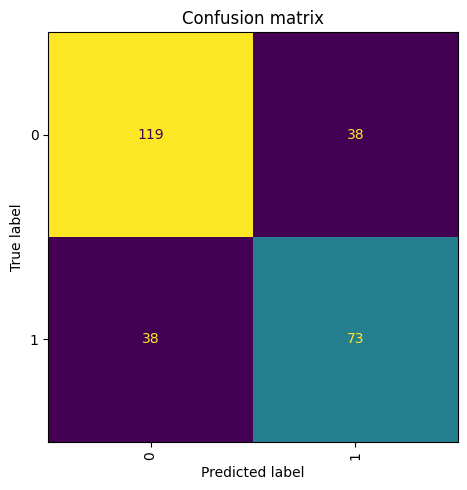

In [49]:
lr_run_name = "lr_run"
model_params = {
    "random_state": 42, 
    "solver": "lbfgs", 
    "class_weight": "balanced"
    }
with mlflow.start_run(run_name=lr_run_name) as run:
    model_lr = LogisticRegression(**model_params)
    model_lr.fit(X_train, y_train)
    predicts = model_lr.predict(X_test)
    report = classification_report(y_test, predicts, output_dict=True)

    mlflow.log_metric("accuracy", report.pop("accuracy"))
    for class_or_avg, metric_dict in report.items():
        if class_or_avg == "macro avg":
            break
        for metric, value in metric_dict.items():
            mlflow.log_metric(class_or_avg + "_" + metric, value)

    mlflow.log_params(model_params)

    mlflow.sklearn.log_model(
        sk_model=model_lr,
        input_example=X_test[:10],
        artifact_path=f"mlflow/{lr_run_name}/model",
    )

    fig = conf_matrix(y_test, predicts)
    mlflow.log_figure(fig, f"{lr_run_name}_confusion_matrix.png")
fig

## Run_2: Random Forest

/Users/uri/Library/Caches/pypoetry/virtualenvs/mlops-ds-ZI2KSMWs-py3.12/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/uri/Library/Caches/pypoetry/virtualenvs/mlops-ds-ZI2KSMWs-py3.12/lib/python3.12/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With 

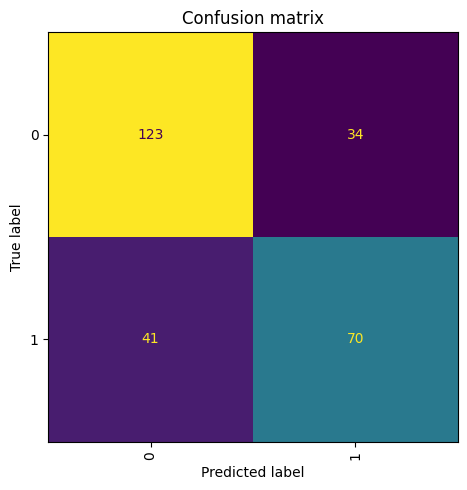

In [50]:
rf_run_name = "rf_run"
model_params = {
    "random_state": 42,
    "min_samples_leaf": 3,
    "class_weight": "balanced"
    }
with mlflow.start_run(run_name=rf_run_name) as run:
    model_rf = RandomForestClassifier(**model_params)
    model_rf.fit(X_train, y_train)
    predicts = model_rf.predict(X_test)
    report = classification_report(y_test, predicts, output_dict=True)

    mlflow.log_metric("accuracy", report.pop("accuracy"))
    for class_or_avg, metric_dict in report.items():
        if class_or_avg == "macro avg":
            break
        for metric, value in metric_dict.items():
            mlflow.log_metric(class_or_avg + "_" + metric, value)

    mlflow.log_params(model_params)

    mlflow.sklearn.log_model(
        sk_model=model_rf,
        input_example=X_test[:10],
        artifact_path=f"mlflow/{rf_run_name}/model",
    )

    fig = conf_matrix(y_test, predicts)
    mlflow.log_figure(fig, f"{rf_run_name}_confusion_matrix.png")
fig